# Imports


In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import PIL

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Build Dataset



In [ ]:
class Shoes_Classification_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, ResizedCrop=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file,encoding='ISO-8859-1')
        self.root_dir = root_dir
        self.transform = transform
        self.ResizedCrop = ResizedCrop
        self.mi_dict = {}
        self.scale = [0,0.8,0.5,0.9,0.7,0.6,0.4,0.3,0.2,0.1,0.09,0.8,0.07,0.085,0.075]
        self.crop = {}

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        imagen = io.imread(img_name)
        #
        imagen = PIL.Image.open(img_name)
        #
        #print('idx: {}'.format(idx))
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.asarray(landmarks)
        landmarks = landmarks.astype('long').reshape(-1, 6)
        #landmarks = landmarks.transpose()
                
        if self.transform:
            imagen = self.transform(imagen)

            if self.ResizedCrop:
              i =  self.mi_dict.get(img_name,0)
              j =  self.crop.get(idx,0)
              if j == 0:                         
                self.mi_dict[img_name] = self.mi_dict.get(img_name,0) + 1
                self.crop[idx] = i 
              else:
                i=j   
              #print(i)
              
              if i > 0:
                #print('RESCALE')
                #print(i)
                reScale = self.scale[i]
                #print(reScale)
                ResizedCrop = transforms.Compose([
                    transforms.RandomResizedCrop((32,32), scale=(reScale, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
                ])
            
                imagen = ResizedCrop(imagen)

        return imagen,landmarks

In [ ]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
train_dataset = Shoes_Classification_Dataset(csv_file='drive/My Drive/shoes/train_dataset.csv',
                                    root_dir='drive/My Drive/shoes/',
                                    transform=data_transform,
                                    ResizedCrop = True)

test_dataset = Shoes_Classification_Dataset(csv_file='drive/My Drive/shoes/test_dataset.csv',
                                    root_dir='drive/My Drive/shoes/',
                                    transform=data_transform,
                                    ResizedCrop = False)

tags = ('Acordonado','Plataforma','Taco','Hebilla','Tachas')
classes = ('bota','deportivo','zapato','sandalia')



# Build DataLoader

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=2)

test_dl = DataLoader(test_dataset, batch_size=4,
                        shuffle=True, num_workers=2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Modelo

In [ ]:
nn.Conv2d?

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class Model(nn.Module):

  def __init__(self, output_size=9):
    super(Model, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
    
    # kernel = 2, stride = 2
    self.max_pool = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)

    self.fc1 = nn.Linear(64*4*4,1024)
    self.fc2 = nn.Linear(1024, output_size)

    self.sigmoid = nn.Sigmoid();

    self.tag1 = nn.Linear(output_size,1)
    self.tag2 = nn.Linear(output_size,1)
    self.tag3 = nn.Linear(output_size,1)
    self.tag4 = nn.Linear(output_size,1)
    self.tag5 = nn.Linear(output_size,1)
    self.classification = nn.Linear(output_size,4)

  def forward(self, X):
    # Recodar que el in
    assert (X.shape[1:] == (3,32,32))
    Z1 = self.conv1(X)
    assert (Z1.shape[1:] == (16,32,32))
    A1 = F.relu(Z1)
    assert (A1.shape[1:] == (16,32,32))
    A1_DS = self.max_pool(A1)
    assert (A1_DS.shape[1:] == (16,16,16))

    Z2 = self.conv2(A1_DS)
    assert (Z2.shape[1:] == (32,16,16))
    A2 = F.relu(Z2)
    assert (A2.shape[1:] == (32,16,16))
    A2_DS = self.max_pool(A2)
    assert (A2_DS.shape[1:] == (32,8,8))

    Z3 = self.conv3(A2_DS)
    assert (Z3.shape[1:] == (64,8,8))
    A3 = F.relu(Z3)
    assert (A3.shape[1:] == (64,8,8))
    A3_DS = self.max_pool(A3)
    assert (A3_DS.shape[1:] == (64,4,4))

    A3_DS = A3_DS.view(-1, 64*4*4)
    Z4 = self.fc1(A3_DS)
    A4 = F.relu(Z4)
    Z5 = self.fc2(A4)
    
    o1 = self.tag1(Z5)
    oo1 = self.sigmoid(o1)

    o2 = self.tag2(Z5)
    oo2 = self.sigmoid(o2)

    o3 = self.tag3(Z5)
    oo3 = self.sigmoid(o3)

    o4 = self.tag4(Z5)
    oo4 = self.sigmoid(o4)

    o5 = self.tag5(Z5)
    oo5 = self.sigmoid(o5)
    
    o6 = self.classification(Z5)

    return oo1, oo2, oo3, oo4, oo5, o6

  def print_layers(self, detailed=False):
    if detailed:
      for name, param in self.named_parameters():
        print(name, param.size())
    else:
      for layer in m.children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {layer}, Parameters: {num_params}") 
    print(f"Total Parameters: {self._num_parameters()}")
    

  def _num_parameters(self):
    return sum(p.numel() for p in self.parameters())

In [ ]:
bce = nn.BCELoss?

# Model Interface

In [ ]:
import torch.optim as optim

class ModelInterface():

  def __init__(self):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.model = Model(9).to(self.device)

  def save_model(self, path='./model.state'):
    
    torch.save(self.model.state_dict(), path)
  
  def load_model(self, path='./model.state'):
    
    self.model.load_state_dict(torch.load(path))

  
  def train(self, epochs, train_dl):
    
    print(f"Training on devide: {self.device}")

    #sigmoid = nn.Sigmoid();
    bce = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

    for epoch in range(epochs):  
      print(f'Running epoch {epoch}')
      running_loss = 0.0
      
      for i, data in enumerate(train_dl, 0):
        
        inputs, labels = data[0].to(self.device), data[1].to(self.device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        o1, o2, o3, o4, o5, o6 = self.model(inputs) 
        
        #acordonado        
        labelAcordonado = torch.tensor([[labels[0][0][0]],[labels[1][0][0]],[labels[2][0][0]]
                                        ,[labels[3][0][0]]],dtype=torch.float)        
        lossAcordonado = bce(o1,labelAcordonado)
        
        #Plataforma
        labelPlataforma = torch.tensor([[labels[0][0][1]],[labels[1][0][1]],[labels[2][0][1]]
                                        ,[labels[3][0][1]]],dtype=torch.float)
        lossPlataforma = bce(o2,labelPlataforma)

        #Taco
        labelTaco = torch.tensor([[labels[0][0][2]],[labels[1][0][2]],[labels[2][0][2]]
                                  ,[labels[3][0][2]]],dtype=torch.float)
        lossTaco = bce(o3,labelTaco)

        #Hebilla
        labelHebilla = torch.tensor([[labels[0][0][3]],[labels[1][0][3]],[labels[2][0][3]],
                                     [labels[3][0][3]]],dtype=torch.float)
        lossHebilla = bce(o4,labelHebilla)

        #Tachas
        labelTachas = torch.tensor([[labels[0][0][4]],[labels[1][0][4]],[labels[2][0][4]],
                                    [labels[3][0][4]]],dtype=torch.float)
        lossTachas = bce(o5,labelTachas)

        #CATEGORIZACION
        labelCATEGORIZACION = torch.tensor([labels[0][0][5],labels[1][0][5],labels[2][0][5],
                                            labels[3][0][5]],dtype=torch.long)
        lossCATEGORIZACION = criterion(o6,labelCATEGORIZACION)     
  
        totalLoss = lossAcordonado + lossPlataforma + lossTaco + lossHebilla + lossTachas + lossCATEGORIZACION
       
        #backward & step
        totalLoss.backward()
                
        optimizer.step()

        # print statistics
        running_loss += totalLoss.item()
        if i % 400 == 399:    # print every 400 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 400))
            
            running_loss = 0.0
            

    print('Finished Training')

  def evaluate(self, test_dl):
    accuracyTag1 = 0
    precisionTag1 = 0
    recallTag1 = 0
    f1Tag1 = 0
    accuracyTag2 = 0
    precisionTag2 = 0
    recallTag2 = 0
    f1Tag2 = 0
    accuracyTag3 = 0
    precisionTag3 = 0
    recallTag3 = 0
    f1Tag3 = 0
    accuracyTag4 = 0
    precisionTag4 = 0
    recallTag4 = 0
    f1Tag4 = 0
    accuracyTag5 = 0
    precisionTag5 = 0
    recallTag5 = 0
    f1Tag5 = 0
    accuracyClass = 0
    

    total = 0
    self.model.eval()
    with torch.no_grad():
      for data in test_dl:
        images, labels = data[0].to(self.device), data[1].to(self.device)
        t1, t2, t3, t4, t5, classif = self.model(images)

        
        #METRICAS TAG1
        target1 = torch.tensor([[labels[0][0][0]],[labels[1][0][0]],[labels[2][0][0]]
                                        ,[labels[3][0][0]]],dtype=torch.float)
        tagArr = []
        for tt in t1:
          itTag = 1. if tt.item() >= 0.7 else 0
          tagArr.append(itTag)
        tagArr = np.array([tagArr]).transpose()  

        accuracyTag1 += accuracy_score(target1.detach(),tagArr)
        precisionTag1 += precision_score(target1.detach(),tagArr)
        recallTag1 += recall_score(target1.detach(),tagArr)
        f1Tag1 += f1_score(target1.detach(),tagArr) 

        #METRICAS TAG2
        target2 = torch.tensor([[labels[0][0][1]],[labels[1][0][1]],[labels[2][0][1]]
                                        ,[labels[3][0][1]]],dtype=torch.float)
        tagArr = []
        for tt in t2:
          itTag = 1. if tt.item() >= 0.7 else 0
          tagArr.append(itTag)
        tagArr = np.array([tagArr]).transpose()  

        accuracyTag2 += accuracy_score(target2.detach(),tagArr)
        precisionTag2 += precision_score(target2.detach(),tagArr)
        recallTag2 += recall_score(target2.detach(),tagArr)
        f1Tag2 += f1_score(target2.detach(),tagArr) 

        #METRICAS TAG3
        target3 = torch.tensor([[labels[0][0][2]],[labels[1][0][2]],[labels[2][0][2]]
                                        ,[labels[3][0][2]]],dtype=torch.float)
        tagArr = []
        for tt in t3:
          itTag = 1. if tt.item() >= 0.7 else 0
          tagArr.append(itTag)
        tagArr = np.array([tagArr]).transpose()  

        accuracyTag3 += accuracy_score(target3.detach(),tagArr)
        precisionTag3 += precision_score(target3.detach(),tagArr)
        recallTag3 += recall_score(target3.detach(),tagArr)
        f1Tag3 += f1_score(target3.detach(),tagArr) 

        #METRICAS TAG4
        target4 = torch.tensor([[labels[0][0][3]],[labels[1][0][3]],[labels[2][0][3]]
                                        ,[labels[3][0][3]]],dtype=torch.float)
        tagArr = []
        for tt in t4:
          itTag = 1. if tt.item() >= 0.7 else 0
          tagArr.append(itTag)
        tagArr = np.array([tagArr]).transpose()  

        accuracyTag4 += accuracy_score(target4.detach(),tagArr)
        precisionTag4 += precision_score(target4.detach(),tagArr)
        recallTag4 += recall_score(target4.detach(),tagArr)
        f1Tag4 += f1_score(target4.detach(),tagArr) 

        #METRICAS TAG5
        target5 = torch.tensor([[labels[0][0][4]],[labels[1][0][4]],[labels[2][0][4]]
                                        ,[labels[3][0][4]]],dtype=torch.float)
        tagArr = []
        for tt in t5:
          itTag = 1. if tt.item() >= 0.7 else 0
          tagArr.append(itTag)
        tagArr = np.array([tagArr]).transpose()  

        accuracyTag5 += accuracy_score(target5.detach(),tagArr)
        precisionTag5 += precision_score(target5.detach(),tagArr)
        recallTag5 += recall_score(target5.detach(),tagArr)
        f1Tag5 += f1_score(target5.detach(),tagArr)                 
              
        
        #METRICAS CLASSIFICATION
        _,cl = torch.max(classif,1)
        target6 = torch.tensor([labels[0][0][5],labels[1][0][5],labels[2][0][5],
                                            labels[3][0][5]],dtype=torch.long)
        
        accuracyClass += accuracy_score(target6.detach(),cl)
        
               
        total += 1

    print('END EVALUATE')
    print('')
    print('METRICAS TAG ACORDONADO')
    print('Accuracy: %d %%' % (100 * accuracyTag1 / total))
    print('Precision: %d %%' % (100 * precisionTag1 / total))
    print('Recall: %d %%' % (100 * recallTag1 / total))
    print('F1: %d %%' % (100 * f1Tag1 / total))
    print('')
    print('METRICAS TAG PLATAFORMA')
    print('Accuracy: %d %%' % (100 * accuracyTag2 / total))
    print('Precision: %d %%' % (100 * precisionTag2 / total))
    print('Recall: %d %%' % (100 * recallTag2 / total))
    print('F1: %d %%' % (100 * f1Tag2 / total))
    print('')
    print('METRICAS TAG TACO')
    print('Accuracy: %d %%' % (100 * accuracyTag3 / total))
    print('Precision: %d %%' % (100 * precisionTag3 / total))
    print('Recall: %d %%' % (100 * recallTag3 / total))
    print('F1 Score: %d %%' % (100 * f1Tag3 / total))
    print('')
    print('METRICAS TAG HEBILLA')
    print('Accuracy: %d %%' % (100 * accuracyTag4 / total))
    print('Precision: %d %%' % (100 * precisionTag4 / total))
    print('Recall: %d %%' % (100 * recallTag4 / total))
    print('F1 Score: %d %%' % (100 * f1Tag4 / total))
    print('')
    print('METRICAS TAG TACHAS')
    print('Accuracy: %d %%' % (100 * accuracyTag5 / total))
    print('Precision: %d %%' % (100 * precisionTag5 / total))
    print('Recall: %d %%' % (100 * recallTag5 / total))
    print('F1 Score: %d %%' % (100 * f1Tag5 / total))
    print('')
    print('METRICAS CLASIFICACION')
    print('Accuracy: %d %%' % (100 * accuracyClass / total))
    print('')

# TRAINING

# First convd before training

In [ ]:
mi = ModelInterface()

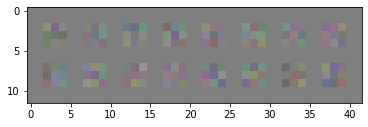

In [ ]:
weight_tensor = mi.model.conv1.weight.data

imshow(torchvision.utils.make_grid(weight_tensor))

# Train

In [ ]:
mi.train(12, train_dl)

Training on devide: cpu
Running epoch 0
[1,   400] loss: 3.931
[1,   800] loss: 3.566
[1,  1200] loss: 3.074
[1,  1600] loss: 2.866
[1,  2000] loss: 2.594
[1,  2400] loss: 2.415
[1,  2800] loss: 2.362
Running epoch 1
[2,   400] loss: 2.119
[2,   800] loss: 2.116
[2,  1200] loss: 1.991
[2,  1600] loss: 2.036
[2,  2000] loss: 1.917
[2,  2400] loss: 2.105
[2,  2800] loss: 1.979
Running epoch 2
[3,   400] loss: 1.725
[3,   800] loss: 1.707
[3,  1200] loss: 1.774
[3,  1600] loss: 1.724
[3,  2000] loss: 1.691
[3,  2400] loss: 1.867
[3,  2800] loss: 1.734
Running epoch 3
[4,   400] loss: 1.569
[4,   800] loss: 1.514
[4,  1200] loss: 1.571
[4,  1600] loss: 1.535
[4,  2000] loss: 1.510
[4,  2400] loss: 1.587
[4,  2800] loss: 1.631
Running epoch 4
[5,   400] loss: 1.367
[5,   800] loss: 1.311
[5,  1200] loss: 1.384
[5,  1600] loss: 1.426
[5,  2000] loss: 1.466
[5,  2400] loss: 1.454
[5,  2800] loss: 1.453
Running epoch 5
[6,   400] loss: 1.180
[6,   800] loss: 1.147
[6,  1200] loss: 1.280
[6,  1

In [ ]:
mi.save_model('drive/My Drive/shoes/model.state')

# Evaluate

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [ ]:
mi.load_model('drive/My Drive/shoes/model.state')

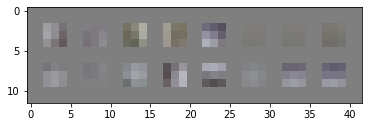

In [ ]:
weight_tensor = mi.model.conv1.weight.data

imshow(torchvision.utils.make_grid(weight_tensor))

In [ ]:
mi.evaluate(test_dl)

END EVALUATE

METRICAS TAG ACORDONADO
Accuracy: 90 %
Precision: 89 %
Recall: 87 %
F1: 87 %

METRICAS TAG PLATAFORMA
Accuracy: 84 %
Precision: 18 %
Recall: 15 %
F1: 16 %

METRICAS TAG TACO
Accuracy: 94 %
Precision: 25 %
Recall: 24 %
F1 Score: 24 %

METRICAS TAG HEBILLA
Accuracy: 86 %
Precision: 10 %
Recall: 9 %
F1 Score: 9 %

METRICAS TAG TACHAS
Accuracy: 95 %
Precision: 0 %
Recall: 0 %
F1 Score: 0 %

METRICAS CLASIFICACION
Accuracy: 86 %



#Test

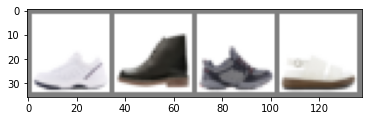

tensor([[[1, 0, 0, 0, 0, 1]],

        [[1, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 1]],

        [[0, 0, 0, 1, 0, 3]]])
Acordonado
deportivo

Acordonado
bota

Acordonado
deportivo

Hebilla
sandalia

PREDICTION

Acordonado
deportivo

Acordonado
bota

Acordonado
deportivo

zapato



In [ ]:
dataiter = iter(test_dl)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print(labels)
for l in labels:
  for j in range(5):
    tag = 1. if l[0][j].item() >= 0.7 else 0
    if tag == 1.:
      print(tags[j])

  print(classes[l[0][5]])  
  print('')  

print('PREDICTION')
print('')
t1, t2, t3, t4, t5, classif = mi.model(images)

_, predicted = torch.max(classif, 1)
for j in range(4):
  tag = 1. if t1[j].item() >= 0.7 else 0
  if tag == 1.:
    print(tags[0])
  tag = 1. if t2[j].item() >= 0.7 else 0
  if tag == 1.:
    print(tags[1])
  tag = 1. if t3[j].item() >= 0.7 else 0
  if tag == 1.:
    print(tags[2])
  tag = 1. if t4[j].item() >= 0.7 else 0
  if tag == 1.:
    print(tags[3])
  tag = 1. if t5[j].item() >= 0.7 else 0
  if tag == 1.:
    print(tags[4])  

  print(classes[predicted[j]])
  print('')
  